# Job Decision Analysis

In [45]:
import trimmed_hd_quantile_estimator as hd
from datetime import date, timedelta

import numpyro
import numpyro.distributions as dist
import numpyro.distributions.util as util
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, MixedHMC, HMC
from jax import random
import jax.numpy as jnp
import plotly.express as px
import plotly.io as pio
import numpy as np
from scipy import stats
import pyvinecopulib as pv
import graphviz
import funsor
import pysdtest as stochdom

In [8]:
rng_key = random.PRNGKey(123)
pio.renderers.default = "svg"

# Description
A family member needs help with a job decision.  There are two alternatives A1 and A2, which send the decision maker on different stochastic journeys to retirement.

1. Maintain current employment until one of the following occurs:
- your `vestment_date` is reached
- you start a new UT state government job other than Lands Program Manager
- you are discharged/layed off

Meanwhile, seek new employment with the UT state government with effort level `cur_pre_v_ut_effort_level_a` and other kinds of employment (to start after vestment) with effort level `cur_pre_v_non_ut_effort_level_a`.  However, if you're still at your curent position on `vestment_date - 90 days`, then thereafter seek new employment (to start after vestment) somewhere other than the UT state government with effort level `cur_pre_v_non_ut_effort_level_b`. 

If you receive a non-UT-state-government job offer, then only switch to it once `vestment_date` has been reached.

If your `vestment_date` is reached and you have no job offers, then seek employment somewhere other than the UT state government with effort level `post_v_non_ut_effort_level_a` while maintaining current position.

If new employment is obtained with the UT state government (other than Lands Program Manager) prior to `vestment_date`, then accept it and start working in the new role ASAP.



In any case, maintain whatever new employment is found until retirement on `retirement_date`.


If you're still at your curent position on `vestment_date - 100 days`, then actively seek new employment from that date until re-employment with the understanding that you would start the new employment on `vestment_date + 1 day` or shortly thereafter.  In other words, don't start new employment until you reach the year mark.  Nevertheless, actively seek new Utah state government employment before `vestment_date - 100 days` if your subjective probability of being laid off before the year mark rises higher than 50%.  In any case, maintain whatever new employment is found until retirement on `retirement_date`.

2. Accept job offer for Lands Program Manager.  Begin working in that new position shortly thereafter until retirement on `retirement_date`.

## Assumptions
- We imagine ourselves at the time of retirement looking back on the outcomes of our decision.  We try to predict *now* how we will feel *then* about those outcomes.
- We use multiple-criteria decision analysis (specifically multi-attribute utility theory).  Each alternative is valued across several attributes.  The order of these attributes from most important to least important is:
    1. monetary_considerations
    2. emotional_intangibles  
- We assume that the above set of attributes possesses mutual [additive independence](https://en.wikipedia.org/wiki/Multi-attribute_utility#Additive_independence).  Surrogate weights are given to each attribute using the sum-reciprocal method.

> Burk, R. C., & Nehring, R. M. (2023). An empirical comparison of rank-based surrogate weights in additive multiattribute decision analysis. Decision Analysis, 20(1), 55-72.





Fixed Parameters:

- `personal_401k_contribution` = 0.05 (as a proportion of pay). This is for the next year.
- `employer_matching_401k_contribution` = 0 (as a proportion of `personal_401k_contribution`)
- `tier_2_employer_401k_contribution` = 0.14 (as a proportion of pay). See [this](https://www.urs.org/documents/byfilename/%7CPublic%20Web%20Documents%7CURS%7CDC%7C401k_SPD_SW%7C%7Capplication%7Cpdf/) for more information on 401(k) plans within the Utah Retirement System.
- `current_401k_transferrable_funds` = 2737.71
- `current_401k_nontransferrable_funds` = 18646.47
- `current_debt` = 5000
- `utility_of_3_day_weekend` = 100. This is the amount that one 3-day weekend is worth in dollars.
- `days_until_retirement` = 5*365
- `retirement_date` = 2030-07-01
- `vestment_date` = 2025-07-01


Random Variables:

- `initial_health_of_local_economy`: Given on a scale of 1-7. 1: Terrible. 2: Moderately poor. 3: Slightly poor. 4: Neither good nor bad. 5: Slightly good. 6: Moderately good. 7: Amazing.  Here, local means within commuting distance.
- `health_of_local_economy_at_retirement`: Given on a scale of 1-7. 1: Terrible. 2: Moderately poor. 3: Slightly poor. 4: Neither good nor bad. 5: Slightly good. 6: Moderately good. 7: Amazing.
- `slope_of_health_of_local_economy = (health_of_local_economy_at_retirement - initial_health_of_local_economy + is_laid_off_factor) / days_until_retirement`
- `health_of_local_economy_at_time_t = round(initial_health_of_local_economy + slope_of_health_of_local_economy * t)` where t is the number of days since time 0. But, if `health_of_local_economy_at_time_t < 1`, then `health_of_local_economy_at_time_t = 1`.  Else if `health_of_local_economy_at_time_t > 7`, then `health_of_local_economy_at_time_t = 7`.

- `initial_health_of_state_economy`: Given on a scale of 1-7. 1: Terrible. 2: Moderately poor. 3: Slightly poor. 4: Neither good nor bad. 5: Slightly good. 6: Moderately good. 7: Amazing.
- `health_of_state_economy_at_retirement`: Given on a scale of 1-7. 1: Terrible. 2: Moderately poor. 3: Slightly poor. 4: Neither good nor bad. 5: Slightly good. 6: Moderately good. 7: Amazing.
- `slope_of_health_of_state_economy = (health_of_state_economy_at_retirement - initial_health_of_state_economy + 0.9*is_laid_off_factor) / days_until_retirement`
- `health_of_state_economy_at_time_t = round(initial_health_of_state_economy + slope_of_health_of_state_economy * t)` where t is the number of days since time 0. But, if `health_of_state_economy_at_time_t < 1`, then `health_of_state_economy_at_time_t = 1`.  Else if `health_of_state_economy_at_time_t > 7`, then `health_of_state_economy_at_time_t = 7`.

- `initial_health_of_national_economy`: Given on a scale of 1-7. 1: Terrible. 2: Moderately poor. 3: Slightly poor. 4: Neither good nor bad. 5: Slightly good. 6: Moderately good. 7: Amazing.
- `health_of_national_economy_at_retirement`: Given on a scale of 1-7. 1: Terrible. 2: Moderately poor. 3: Slightly poor. 4: Neither good nor bad. 5: Slightly good. 6: Moderately good. 7: Amazing.
- `slope_of_health_of_national_economy = (health_of_national_economy_at_retirement - initial_health_of_national_economy + 0.8*is_laid_off_factor) / days_until_retirement`
- `health_of_national_economy_at_time_t = round(initial_health_of_national_economy + slope_of_health_of_national_economy * t)` where t is the number of days since time 0. But, if `health_of_national_economy_at_time_t < 1`, then `health_of_national_economy_at_time_t = 1`.  Else if `health_of_national_economy_at_time_t > 7`, then `health_of_national_economy_at_time_t = 7`.

- `initial_financial_health_of_current_employer`: Given on a scale of 1-7. 1: Terrible. 2: Moderately poor. 3: Slightly poor. 4: Neither good nor bad. 5: Slightly good. 6: Moderately good. 7: Amazing.
- `financial_health_of_current_employer_at_year_mark`: Given on a scale of 1-7. 1: Terrible. 2: Moderately poor. 3: Slightly poor. 4: Neither good nor bad. 5: Slightly good. 6: Moderately good. 7: Amazing.
- `slope_of_financial_health_of_current_employer = (financial_health_of_current_employer_at_year_mark - initial_financial_health_of_current_employer) / 365`

- `financial_health_of_current_employer_at_time_t = round(initial_financial_health_of_current_employer + slope_of_financial_health_of_current_employer * t + is_laid_off_factor)` where `t` is the number of days since time 0. But, if `financial_health_of_current_employer_at_time_t < 1`, then `financial_health_of_current_employer_at_time_t = 1`.  Else if `financial_health_of_current_employer_at_time_t > 7`, then `financial_health_of_current_employer_at_time_t = 7`.

- `prob_laid_off`: The probability of being laid off from the current position before the one year mark. Note that `prob_laid_off + prob_salary_decrease + prob_salary_increase < 1` with the remaining probability density representing the probability of the current salary staying the same up to the one year mark.
- `is_laid_off`: Bernoulli random variable with a value of 1 if you are laid off before the 1-year mark.
- `is_laid_off_factor`: Takes a value of -1 if `is_laid_off == 1`; otherwise, takes a value of 1.
- `additional_days_employed_in_current_job`: The support for this random variable is positive integers up to 365.

- `prob_salary_decrease`: The probability of the current salary being decreased. Note that `prob_laid_off + prob_salary_decrease + prob_salary_increase < 1` with the remaining probability density representing the probability of the current salary staying the same up to the one year mark. 
- `is_salary_decreased`: Bernoulli random variable with a value of 1 if your salary is decreased before the 1-year mark.

- `prob_salary_increase`: The probability of the current salary being increased. Note that `prob_laid_off + prob_salary_decrease + prob_salary_increase < 1` with the remaining probability density representing the probability of the current salary staying the same up to the one year mark.
- `is_salary_increased`: Bernoulli random variable with a value of 1 if your salary is increased before the 1-year mark.

- `is_salary_constant`: Bernoulli random variable with a value of 1 if your salary remains the same up until the 1-year mark. The probability of success is `1 - (prob_laid_off + prob_salary_decrease + prob_salary_increase)`.

- `prob_hire_after_layoff`: The probability of being hired after being prematurely layed off by the current employer.
- `days_from_layoff_to_next_hire`: If a layoff occurs, how many days would it take until you are hired for another job?
- `prob_hire_after_year_mark`: The probability of being hired after reaching the year mark.

- `prob_necessary_move_after_layoff`: The probability that it is necessary to move after being layed off in order to be rehired.
- ``
- `prob_necessary_move_after_year_mark`: The probability that it is necessary to move in order to continue working for another employer after the year mark.

8. `annualized_ror_for_401k_transferrable_funds`: Annualized rate of return is calculated [here](https://en.wikipedia.org/wiki/Rate_of_return#Annualization). This will be used for the next year. 
9. `annualized_ror_for_401k_nontransferrable_funds`: This will be used for the next year.
10. `total_debt_payments_for_next_year`
11. `remaining_debt_at_end_of_year`
12. `days_until_debt_payoff`
13. `cucumulative_wages_earned_upon_retirement`: How much money was made from working since the decision was made to stay on the job?
14. `number_of_wage_changes`: How many times is your wage changed before the year is up or you are laid off?
15. `days_with_salary`: Random vector with length `number_of_wage_changes + 1`. The components represent the number of days between wage changes.








In [ ]:
vestment_date = date(2025, 7, 1)
retirement_date = date(2030, 7, 1)
(retirement_date - vestment_date).days

1826

## Other Modeling Assumptions

For monetary considerations, we use the utility function $u:\mathbb{R}\rightarrow\left(-\infty, \infty\right)$ with 

$$ u(x) =   \left\{
\begin{array}{ll}
      x - \frac{1}{2}x^2, & x<0 \\
      \text{ln}\left(x + 1\right), & x \geq 0
\end{array} 
\right.  
$$

# Useful classes and functions

In [3]:
def get_sr_weights(n:int) -> np.ndarray:
    """Get the sum-reciprocal surrogate weights for each of
    
    the n attributes.
    Source: https://doi.org/10.1287/deca.2022.0456
    """
    w = np.ones(shape=(n,))

    ranks = np.arange(
        start=1,
        stop=n + 1,
        dtype=np.int64
    )

    reciprocal_ranks = w / ranks
  
    fracs = (n + 1 - ranks)/n

    numerators = fracs + reciprocal_ranks

    denominator = np.sum(
        a=numerators,
        axis=0
    )

    w = numerators / denominator

    return w


We will use the modified-PERT distribution as part of our modeling.  Here is the class and an example of using it.

In [4]:
# https://realpython.com/python-super/#an-overview-of-pythons-super-function
class Pert(dist.Beta):
    """Class for modified-PERT distribution from numpyro
    with parameters
    a: min
    b: mode
    c: max
    gamma: Lower values of gamma make for a
        distribution that is less peaked 
        at the mode.
        gamma > 0
    """
    def __init__(self, a, b, c, gamma=4):
        # https://pubsonline.informs.org/doi/epdf/10.1287/ited.1080.0013
        # Davis 2008 formula for conversion
        # between PERT and beta distributions
        # https://en.wikipedia.org/wiki/PERT_distribution#The_modified-PERT_distribution
        mu = (a + gamma * b + c)/(gamma + 2)
        # https://reference.wolfram.com/language/ref/PERTDistribution.html
        sigma_squared = (c - a - b*gamma + c*gamma)*(c + b*gamma - a * (1 + gamma))/((2 + gamma)**2 * (3 + gamma))
        alpha_plus_beta = (mu - a)*(c - mu)/sigma_squared - 1 
        alpha = (mu - a)/(c - a)*alpha_plus_beta
        beta = (c - mu)/(c - a)*alpha_plus_beta
        concentration1 = alpha
        concentration0 = beta
        super().__init__(concentration1, concentration0)

In [5]:
a = 69.5
b = 74
c = 76
gamma = 1
pert = Pert(a, b, c, gamma)
# https://num.pyro.ai/en/0.7.1/getting_started.html
y = a + pert.sample(key=rng_key, sample_shape=(100_000,))*(c - a)

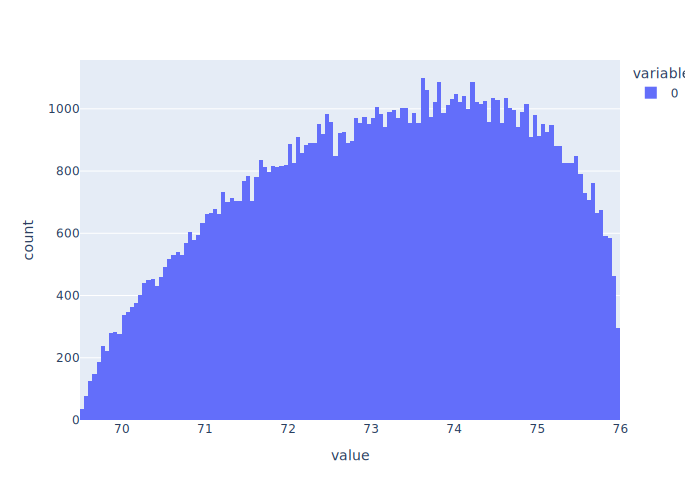

In [10]:
px.histogram(y)

In [90]:
def hazard(t, a_1, t_1, peak, t_2, k_2, c):
    # k_1 is the exponential growth rate 
    # for the first part.
    k_1 = 1/t_1*jnp.log(peak/a_1)

    h = a_1 * jnp.exp(k_1 * t)

    h_with_2 = jnp.where(
        t > t_1,
        peak,
        h
    )
    h_with_3 = jnp.where(
        t > t_2,
        (peak - c)*jnp.exp(-k_2 * (t - t_2)) + c,
        h_with_2
    )

    return h_with_3

0.5161956
0.5721314


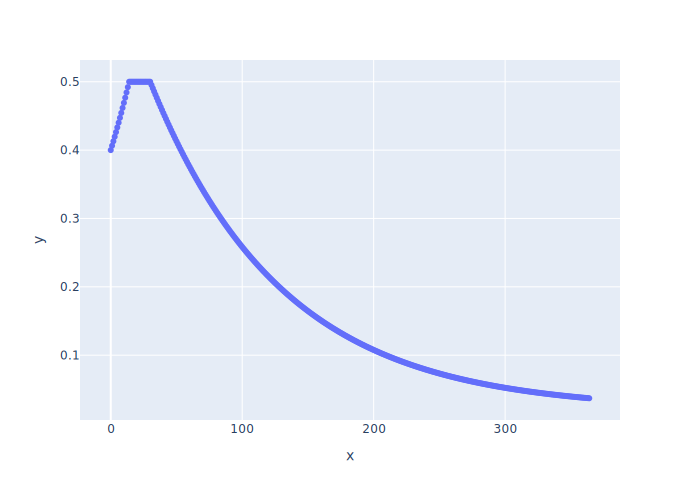

In [92]:
t = np.arange(365)
y = hazard(
    t=t,
    a_1=0.4,
    t_1=14,
    peak=0.5,
    t_2=30,
    k_2=0.01,
    c=0.02
)
px.scatter(
    x=t,
    y=y
)

In [20]:
def unemp_to_emp_prob(days_unemp, start=0.8, decay=0.015, end=0.02):
    """Given how long you have been unemployed, `days_unemp`,
    
    compute the probability of being rehired.

    Args:
        start: 0.05 <= start <= 0.8
        decay: 0.001 <= decay <= 0.1
        end: 0 <= end <= 0.05
    """
    return start*jnp.exp(-decay * days_unemp) + end

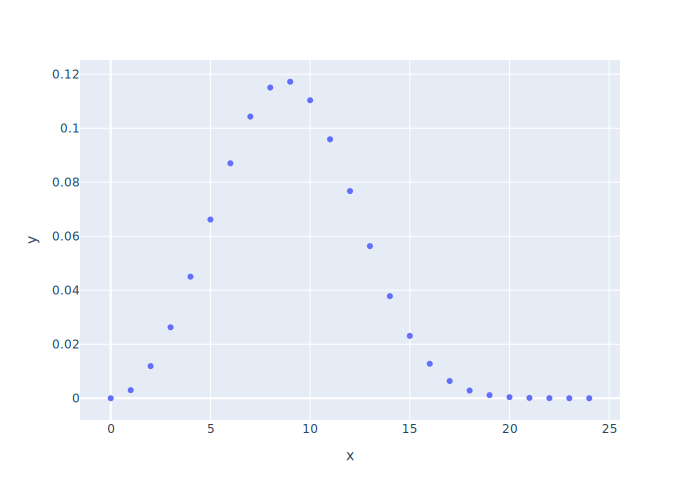

In [73]:
px.scatter(
    x=np.arange(25),
    y=jnp.exp(dist.Weibull(
    scale=10,
    concentration=3
).log_prob(np.arange(25))))

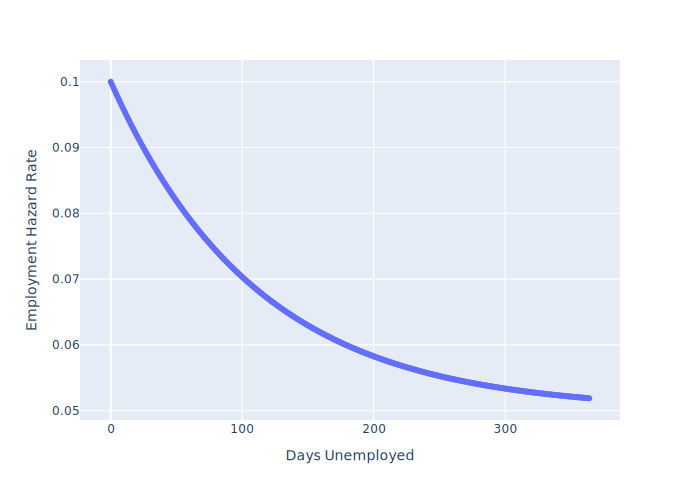

In [43]:
px.scatter(
    x=np.arange(365),
    y=unemp_to_emp_prob(
        days_unemp=np.arange(365),
        start=0.05,
        decay=0.009,
        end=0.05
    ),
    labels={
        "x": "Days Unemployed",
        "y": "Employment Hazard Rate"
    }
)

In [22]:
def days_unemployed_cdf(days_unemp, start, decay, end):
    return 1 - jnp.exp(
        (start/decay)*jnp.exp(-decay * days_unemp) - end*days_unemp - start/decay
    )

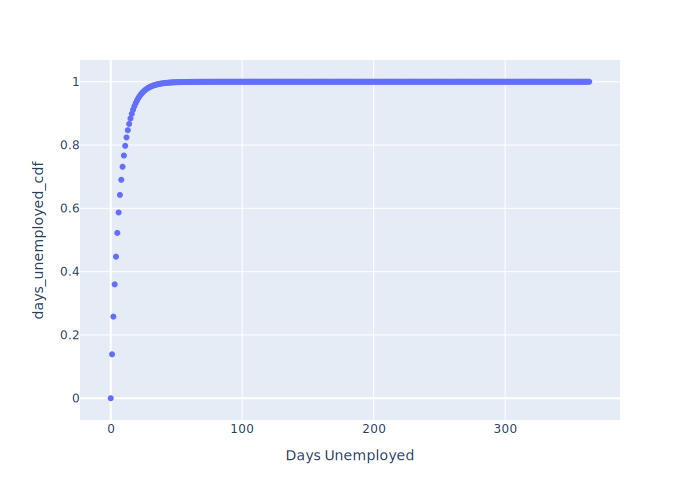

In [40]:
px.scatter(
    x=np.arange(365),
    y=days_unemployed_cdf(
        days_unemp=np.arange(365),
        start=0.1,
        decay=0.009,
        end=0.05
    ),
    labels={
        "x": "Days Unemployed",
        "y": "days_unemployed_cdf"
    }
)

In [24]:
def days_unemployed_lpdf(days_unemp, start, decay, end):
    return jnp.log(start*jnp.exp(-decay*days_unemp + end)) + start/decay*jnp.exp(-decay*days_unemp) - end*days_unemp - start/decay

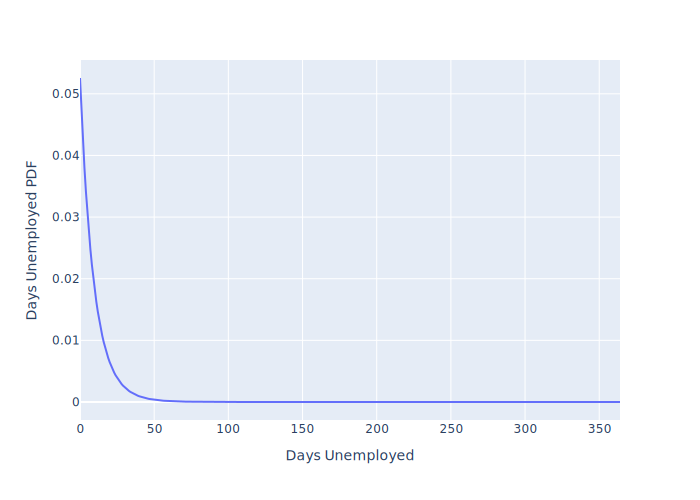

In [42]:
px.line(
    x=np.arange(365),
    y=jnp.exp(days_unemployed_lpdf(
        days_unemp=np.arange(365),
        start=0.05,
        decay=0.009,
        end=0.05
    )),
    labels={
        "x": "Days Unemployed",
        "y": "Days Unemployed PDF"
    }
)

In [317]:
class JustinDistribution(dist.Distribution):
    """Class for modeling time-to-failure."""
    arg_constraints = {
        "y_0": dist.constraints.interval(0.05, 0.8),
        "t_1": dist.constraints.positive,
        "peak": dist.constraints.interval(0, 1),
        "t_2": dist.constraints.positive,
        "k_2": dist.constraints.interval(0.001, 0.1),
        "c": dist.constraints.interval(0, 0.05)
    }
    # We put that the support is positive even though
    # it is really all non-negative real numbers.
    # I don't think it makes a difference.
    support = dist.constraints.positive
    def __init__(self, y_0, k_1, t_1, peak, t_2, k_2, c):
        """
        Args:
            y_0: 0 <= y_0
            k_1: any non-zero real number. k_1*t_1 < 25.
            t_1: t_1 > 0. k_1*t_1 < 25.
            peak: 0 <= peak
            t_2: t_1 <= t_2
            k_2: k_2 < 0
            c: c >= 0
        """
        promoted_shapes = util.promote_shapes(y_0, k_1, t_1, peak, t_2, k_2, c)
        y_0 = promoted_shapes[0]
        k_1 = promoted_shapes[1]
        t_1 = promoted_shapes[2]
        peak = promoted_shapes[3]
        t_2 = promoted_shapes[4] 
        k_2 = promoted_shapes[5] 
        c = promoted_shapes[6]

        # Introduce any other variable that we may want to use later.
        a_1 = (y_0 - peak)/(1-jnp.exp(k_1 * t_1))

        self.a_1 = a_1
        
        # Save others to self.
        self.y_0 = y_0
        self.k_1 = k_1
        self.t_1 = t_1
        self.peak = peak
        self.t_2 = t_2
        self.k_2 = k_2
        self.c = c
        
        super().__init__(batch_shape=jnp.shape(peak), event_shape=())

    def sample(self, key, sample_shape=()):
        raise NotImplementedError
    
    def hazard(self, t):
        """P(T = t | T >= t)"""
        a_1 = self.a_1
        y_0 = self.y_0
        k_1 = self.k_1
        t_1 = self.t_1
        peak = self.peak
        t_2 = self.t_2 
        k_2 = self.k_2 
        c = self.c

        part_0 = jnp.exp(k_1 * t_1)
        # The hazard function is defined piecewise. 
        # The pieces are below.
        h_1 = a_1 * jnp.exp(k_1 * t) + (peak - y_0 * part_0)/(1 - part_0)
        h_2 = peak
        h_3 = (peak - c)*jnp.exp(k_2 * (t - t_2)) + c

        h_with_12 = jnp.where(
            t > t_1,
            h_2,
            h_1
        )

        h_with_123 = jnp.where(
            t > t_2,
            h_3,
            h_with_12
        )

        return h_with_123
    

    def cum_haz(self, t):
        """P(T > t)"""
        y_0 = self.y_0
        k_1 = self.k_1
        t_1 = self.t_1
        peak = self.peak
        t_2 = self.t_2 
        k_2 = self.k_2 
        c = self.c

        part_0 = jnp.exp(k_1 * t_1)

        cum_haz_1 = ((y_0 - peak)*(jnp.exp(k_1 * t) - 1) + k_1*(peak - y_0*part_0)*t) / ((1 - part_0)*k_1)

        part_1 = ((y_0 - peak)*(part_0 - 1) + k_1*(peak - y_0*part_0)*t_1) / ((1 - part_0)*k_1)

        cum_haz_2 = part_1 + peak * (t - t_1)

        part_2 = part_1 + peak * (t_2 - t_1)

        cum_haz_3 = part_2 + (peak - c)/k_2*jnp.exp(k_2*(t - t_2)) + c*t - (peak - c)/k_2 - c*t_2

        cum_haz_2_with_1 = jnp.where(
            t > t_1,
            cum_haz_2,
            cum_haz_1
        )

        cum_haz_3_with_21 = jnp.where(
            t > t_2,
            cum_haz_3,
            cum_haz_2_with_1
        )

        return cum_haz_3_with_21
    

    def survival(self, t):
        """P(T > t)"""
        return jnp.exp(-self.cum_haz(t=t))

    def log_prob(self, t):
        h = self.hazard(t=t)
        cum_hazard = self.cum_haz(t=t)

        return jnp.log(h) - cum_hazard

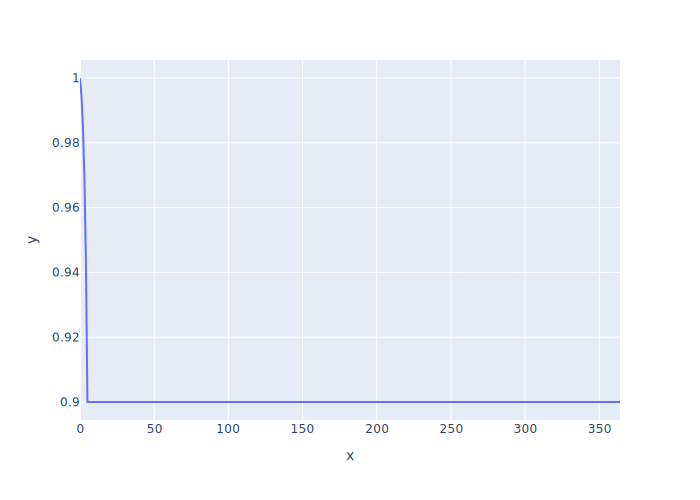

In [376]:
# y_0=0.00001, k_1=0.2, t_1=14, peak=0.8, t_2=17, k_2=-0.1, c=0.006
justin_dist = JustinDistribution(y_0=1, k_1=0.5, t_1=5, peak=0.9, t_2=365, k_2=-0.1, c=2)
t=np.arange(365)
y = justin_dist.hazard(t=t)
px.line(
    x=t,
    y=y
)

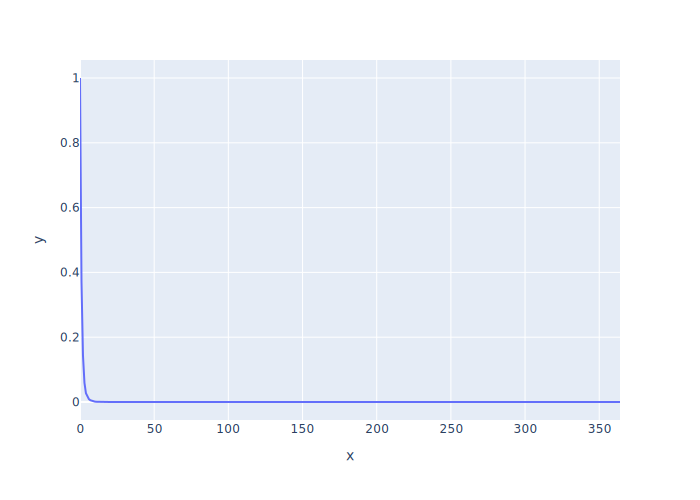

In [372]:
y = justin_dist.survival(t=t)
px.line(
    x=t,
    y=y
)

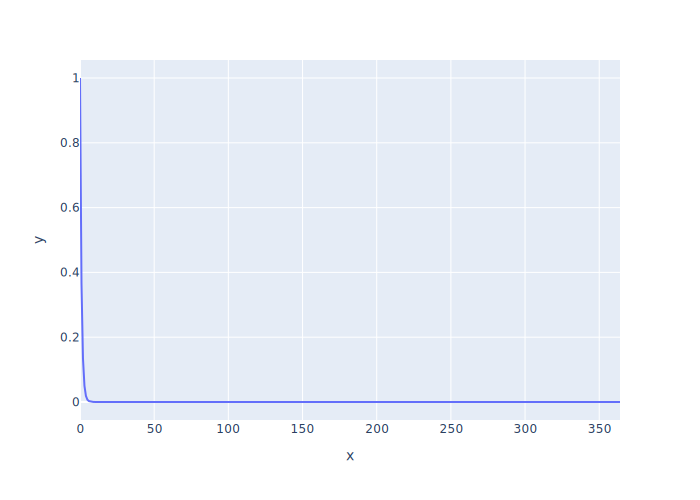

In [377]:
y = jnp.exp(justin_dist.log_prob(t=t))
px.line(
    x=t,
    y=y
)

In [97]:
def failure():
    time_to_failure = numpyro.sample(
        name="time_to_failure",
        fn=JustinDistribution(a_1=0.3, t_1=14, peak=0.8, t_2=17, k_2=0.01, c=0.01)
    )
    return time_to_failure

In [98]:
# Instantiate a `MCMC` object using a NUTS sampler
nuts_kernel_for_failure = NUTS(model=failure)
mcmc_for_failure = MCMC(
        sampler=nuts_kernel_for_failure,
        num_warmup=100,
        num_samples=100,
        num_chains=4
)

# Run the MCMC sampler and collect samples
mcmc_for_failure.run(rng_key=random.PRNGKey(seed=42))

/tmp/ipykernel_194336/895034763.py:3: UserWarning:

There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.

sample: 100%|██████████| 200/200 [00:00<00:00, 1340.88it/s, 67 steps of size 4.94e-02. acc. prob=0.80]


In [99]:
failure_samps = mcmc_for_failure.get_samples()

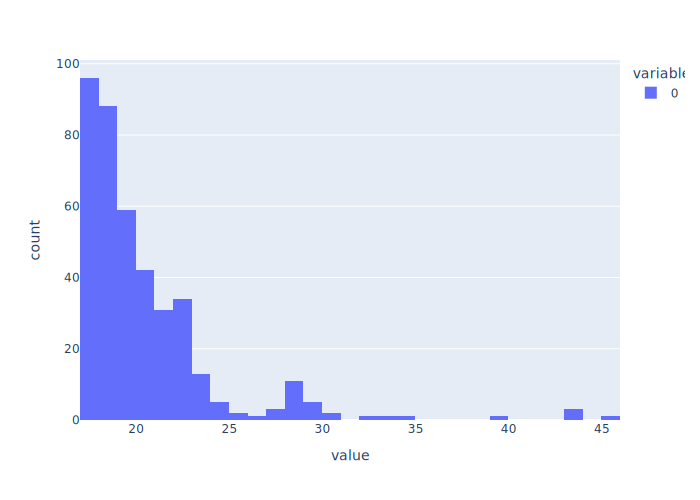

In [100]:
px.histogram(failure_samps["time_to_failure"])

In [ ]:
# https://realpython.com/python-super/#an-overview-of-pythons-super-function
# https://github.com/transferwise/tw-experimentation/blob/578b030b3d6ef09d67c0d5ed0921c95703363507/tw_experimentation/bayes/numpyro_monkeypatch.py#L71
class MixtureGeneralWithEnumSupport(dist.MixtureGeneral):
    """Class to be able to create mixture distributions
    
    with discrete distributions in NumPyro.
    """
    @property
    def has_enumerate_support(self):
        return True

    def enumerate_support(self, expand=True):
        # Assume the 0th distribution in the mixture 
        # has a method of enumerate_support.
        return self.component_distributions[0].enumerate_support(expand=expand)

# Calculate Utility of Alternative A1.

In [11]:
def a1_utility(
    prob_is_laid_off_soon
):
    """Sample from the stochastic utility function

    for staying in the current job.

    Args:
         
        prob_is_laid_off_soon: probability of being laid off within the year

    Returns:  
    """
    # is_laid_off_current_job_soon is 1 if a layoff occurs in the next 
    # 12 months; otherwise, it is 0.
    # is_laid_off_current_job_soon = numpyro.sample(
    #     name="is_laid_off_current_job_soon", 
    #     fn=dist.Bernoulli(prob_is_laid_off_soon),
    #     rng_key=random.PRNGKey(0),
    #     infer={"enumerate": "parallel"}
    # )
    mixing_dist = dist.Categorical(
        probs=jnp.array([prob_is_laid_off_soon, 1 - prob_is_laid_off_soon])
    )
    # When implementing a mixture distribution in NumPyro, 
    # the component distributions are required to have
    # the same support.
    # Do some finagling here to make that a reality.
    common_support = np.zeros(shape=(366,))
    common_support[365] = 1
    common_support_jnp = jnp.array(common_support)
    component_dists = [
        dist.BetaBinomial(
            concentration1=0.5,
            concentration0=0.5,
            total_count=365
        ),
        dist.Categorical(
            probs=common_support_jnp
        )
        # dist.TransformedDistribution(
        #     base_distribution=dist.Delta(v=1),
        #     transforms=dist.transforms.AffineTransform(
        #         loc=0,
        #         scale=365
        #     )    
        # )
    ]
    common_support_2 = dist.constraints.integer_interval(lower_bound=0, upper_bound=365)
    beta_binom_mix = MixtureGeneralWithEnumSupport(
        mixing_distribution=mixing_dist,
        component_distributions=component_dists,
        support=common_support_2
    )
    
    
    # prop_of_year_employed_current_job = 365 * numpyro.sample(
    #     name="prop_of_year_employed_current_job",
    #     fn=dist.Beta(0.5, 0.5),
    #     rng_key=random.PRNGKey(0)
    # )
    # additional_days_employed_in_current_job = numpyro.deterministic(
    #     name="additional_days_employed_in_current_job",
    #     value=jnp.round(prob_is_laid_off_soon \
    #     * prop_of_year_employed_current_job + (1 - prob_is_laid_off_soon) \
    #     * 365)
    # )
    
    # with numpyro.plate(
    #     name="my_plate",
    #     size=5
    # ):
    additional_days_employed_in_current_job = numpyro.sample(
        name="additional_days_employed_in_current_job",
        fn=beta_binom_mix,
        # infer={"enumerate": "parallel"}
    )

    return additional_days_employed_in_current_job
    ##############################
    # additional_months_employed_in_current_job = is_laid_off_current_job_soon * 12 * prop_year_employed_current_job
    # jnp.where(
    #     condition=is_laid_off_current_job_soon,
    #     x=
    # )
    # if laid_off_current_job_soon:
    #     # How many months of employment were
    #     # captured before the layoff?
    #     # arcsine distribution is Beta(0.5, 0.5)
    #     # https://en.wikipedia.org/wiki/Arcsine_distribution
    #     arcsine_dist = dist.Beta(0.5, 0.5)
    #     additional_months_employed_in_current_job = 12 * arcsine_dist.sample(key=rng_key)
    # else:
    #     additional_months_employed_in_current_job = 12
    
    # return additional_months_employed_in_current_job

In [ ]:

a1_utility(
    prob_is_laid_off_soon=0.3
)

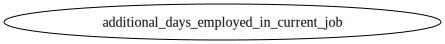

In [12]:
numpyro.render_model(
    model=a1_utility,
    model_args=[0.5],
    render_params=True
)

In [17]:
nuts_kernel = NUTS(model=a1_utility)
hmc_kernel = HMC(model=a1_utility)
hmc_gibbs = DiscreteHMCGibbs(
    inner_kernel=nuts_kernel
)

mixed_hmc = MixedHMC(
    inner_kernel=hmc_kernel   
)

mcmc = MCMC(
        sampler=mixed_hmc,
        num_warmup=100,
        num_samples=100,
        num_chains=4
)

# Run the MCMC sampler and collect samples
mcmc.run(
        rng_key=random.PRNGKey(seed=42),
        prob_is_laid_off_soon=0.7
)

/tmp/ipykernel_300022/619536135.py:11: UserWarning:

There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.

sample: 100%|██████████| 200/200 [00:00<00:00, 1098.31it/s, 1 steps of size 4.65e+18. acc. prob=1.00]


In [14]:
# Instantiate a `MCMC` object using a NUTS sampler
mcmc = MCMC(
        sampler=nuts_kernel,
        num_warmup=100,
        num_samples=100,
        num_chains=4
)

# Run the MCMC sampler and collect samples
mcmc.run(
        rng_key=random.PRNGKey(seed=42),
        prob_is_laid_off_soon=0.7
)

/tmp/ipykernel_300022/1771088140.py:2: UserWarning:

There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.

/tmp/ipykernel_300022/1771088140.py:10: FutureWarning:

Some algorithms will automatically enumerate the discrete latent site additional_days_employed_in_current_job of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.

sample: 100%|██████████| 200/200 [00:02<00:00, 90.07it/s, 1 steps of size 4.65e+18. acc. prob=1.00] 
/tmp/ipykernel_300022/1771088140.py:10: FutureWarning:

Some algorithms will automatically enumerate the discrete latent site additional_days_employed_in_current_job of your model. In the future, enumerated sites need to be marked with `infer={'e

In [18]:
samples = mcmc.get_samples()

In [19]:
samples

{'additional_days_employed_in_current_job': Array([365, 365, 237,   6, 365,   5,  34, 365, 365,  48, 202,   0, 365,
        365, 362, 365,  34, 116,   0, 365, 365,  17, 365, 136,  56,  55,
        196, 360, 362, 345, 365, 347, 294, 191, 215, 134, 146, 365, 365,
        351, 365,   1, 232, 365, 157, 365,  95, 284,  58,  20, 325,   3,
         41,  21, 365, 118,  14, 362,   2, 350,   0,   4,   1, 365, 255,
         12, 365,  11, 191, 214, 167, 365,  87, 365, 207, 365, 365, 365,
        365, 365, 365, 326,  94, 353, 287,   1,  29, 204, 210, 273, 365,
        314,  14, 365, 365, 180, 330,  56, 235, 365, 365,  18, 365, 365,
         29,  27, 365,  80, 154, 365,  28,   6, 118, 250,  61, 214, 364,
         99, 365, 365, 365, 298,   1, 365, 346, 202, 173, 365, 365, 365,
        365, 365, 365,   0, 365, 338, 150, 365, 188, 365, 365, 320,  20,
          3,  13, 365, 217, 365, 157, 258, 338, 365, 132, 216, 197, 112,
        365, 365, 247,  34, 254, 300, 364, 365, 360, 365, 189, 365, 365,
        

In [20]:
px.histogram(samples["additional_days_employed_in_current_job"])